# Advanced Time Series Analysis: Streamlined Boundary Handling

This tutorial demonstrates advanced time series analysis using pytidycensus's built-in functions that automatically handle changing geographic boundaries. You'll analyze DC population and poverty trends (2019-2023) using the new streamlined approach.

## What You'll Learn

1. **Streamlined Time Series**: Using `get_time_series()` for automatic boundary handling
2. **Comparison Analysis**: Using `compare_time_periods()` for detailed comparisons
3. **Variable Classification**: Proper handling of extensive vs intensive variables
4. **Real-world Analysis**: DC demographic trends with changing tract boundaries
5. **Advanced Visualization**: Mapping changes with consistent boundaries

## Prerequisites

- Basic understanding of Census data concepts
- Familiarity with pandas DataFrames
- Census API key for data downloads

## Why Use the New Time Series Functions?

The new functions provide:
- **Automatic Area Interpolation**: Transparent handling of boundary changes
- **Built-in Validation**: Quality checks and conservation tests
- **Streamlined Workflow**: Complex operations reduced to simple function calls
- **Consistent Results**: Industry-standard methods for spatial interpolation

**Previous approach**: Manual interpolation with multiple steps and potential errors
**New approach**: Single function call with automatic boundary handling

## Setup: Install and Import Libraries

This tutorial now requires only basic pytidycensus with time series support.

In [ ]:
# Check if time series functionality is available
import pytidycensus as tc

try:
    from pytidycensus.time_series import get_time_series, compare_time_periods
    print("✅ Time series functionality available")
    TIMESERIES_AVAILABLE = True
except ImportError:
    print("❌ Time series functionality missing")
    print("Install with: pip install pytidycensus[time]")
    TIMESERIES_AVAILABLE = False

print(f"Using pytidycensus version: {tc.__version__}")

if TIMESERIES_AVAILABLE:
    print("\nTime series functions:")
    print("- get_time_series(): Automatic boundary handling")
    print("- compare_time_periods(): Streamlined comparisons")
    print("- Built-in area interpolation with tobler")
else:
    print("\nPlease install time series support to continue with this tutorial.")

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

# Note: geopandas and tobler are automatically available through pytidycensus[time]
# No need to check for them separately

In [ ]:
# Set your Census API key
# Get a free key at: https://api.census.gov/data/key_signup.html

# UNCOMMENT and add your key:
# tc.set_census_api_key("YOUR_API_KEY_HERE")

print("Remember to set your Census API key above!")
print("This tutorial requires actual data downloads.")

## Part 1: Streamlined Time Series Data Collection

Let's collect ACS 5-year data for 2019 and 2023 using the new `get_time_series()` function that automatically handles boundary changes.

In [ ]:
# Use get_time_series for automatic boundary handling
if TIMESERIES_AVAILABLE:
    try:
        # Define variables for demographic analysis
        variables = {
            "total_pop": "B01003_001E",      # Total population
            "poverty_count": "B17001_002E",  # Population below poverty line
            "poverty_total": "B17001_001E"   # Total population for poverty calculation
        }
        
        print("Collecting ACS 5-year time series data...")
        print("Years: 2019 (2015-2019) and 2023 (2019-2023)")
        print("Variables:", list(variables.keys()))
        
        # Single function call handles all boundary complexities
        dc_data = tc.get_time_series(
            geography="tract",
            variables=variables,
            years=[2019, 2023],
            dataset="acs5",
            state="DC",
            base_year=2023,  # Use 2023 boundaries as reference
            extensive_variables=["total_pop", "poverty_count", "poverty_total"],
            intensive_variables=[],  # We'll calculate poverty rate manually
            geometry=True,
            output="wide"
        )
        
        print(f"\n✅ Success! Data shape: {dc_data.shape}")
        print(f"2019 Total Population (interpolated): {dc_data[(2019, 'total_pop')].sum():,}")
        print(f"2023 Total Population: {dc_data[(2023, 'total_pop')].sum():,}")
        
        # Calculate poverty rates for both years
        dc_data['poverty_rate_2019'] = (dc_data[(2019, 'poverty_count')] / 
                                        dc_data[(2019, 'poverty_total')] * 100)
        dc_data['poverty_rate_2023'] = (dc_data[(2023, 'poverty_count')] / 
                                        dc_data[(2023, 'poverty_total')] * 100)
        
        print(f"2019 Average Poverty Rate: {dc_data['poverty_rate_2019'].mean():.1f}%")
        print(f"2023 Average Poverty Rate: {dc_data['poverty_rate_2023'].mean():.1f}%")
        
        # Key insight: Boundary changes handled automatically!
        print(f"\n📊 The function automatically:")
        print(f"   • Detected boundary changes between 2019 and 2023")
        print(f"   • Interpolated 2019 data to 2023 tract boundaries")
        print(f"   • Preserved population totals during interpolation")
        print(f"   • All analysis uses consistent 2023 boundaries")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Make sure you have set your Census API key!")
        dc_data = None
        
else:
    print("Time series functionality not available")
    dc_data = None

In [27]:
# Step 2: Get 2023 ACS 5-year data with geometry
# This represents the 2019-2023 American Community Survey

try:
    dc_2023 = tc.get_acs(
        geography="tract",
        variables={
            "total_pop": "B01003_001E",      # Total population
            "poverty_count": "B17001_002E",  # Population below poverty line
            "poverty_total": "B17001_001E"   # Total population for poverty calculation
        },
        state="DC",
        year=2023,
        survey="acs5",
        geometry=True,
        output="wide"
    )
    
    # Calculate poverty rate
    dc_2023['poverty_rate'] = (dc_2023['poverty_count'] / dc_2023['poverty_total'] * 100)
    
    print(f"2023 ACS Data: {len(dc_2023)} tracts")
    print(f"Total population: {dc_2023['total_pop'].sum():,}")
    print(f"Average poverty rate: {dc_2023['poverty_rate'].mean():.1f}%")
    print(f"Coordinate system: {dc_2023.crs}")
    
    # Check for boundary changes
    if dc_2019 is not None:
        tract_change = len(dc_2023) - len(dc_2019)
        print(f"\nBoundary Changes:")
        print(f"Tract count change: {tract_change:+d}")
        
        # Check for common tracts
        common_tracts = set(dc_2019['GEOID']) & set(dc_2023['GEOID'])
        print(f"Unchanged tracts: {len(common_tracts)}")
        print(f"Changed/new tracts: {len(dc_2023) - len(common_tracts)}")
        
except Exception as e:
    print(f"Error fetching 2023 data: {e}")
    dc_2023 = None

Getting data from the 2019-2023 5-year ACS
Loading tract boundaries...
2023 ACS Data: 206 tracts
Total population: 672,079
Average poverty rate: 15.6%
Coordinate system: EPSG:4269

Boundary Changes:
Tract count change: +27
Unchanged tracts: 154
Changed/new tracts: 52


NOTE: There were 52 new or changed tracts in DC between 2019 and 2023.

### Visualizing Boundary Changes

Let's create maps to visualize how tract boundaries changed between 2019 and 2023, and see the differences in both population and poverty patterns.

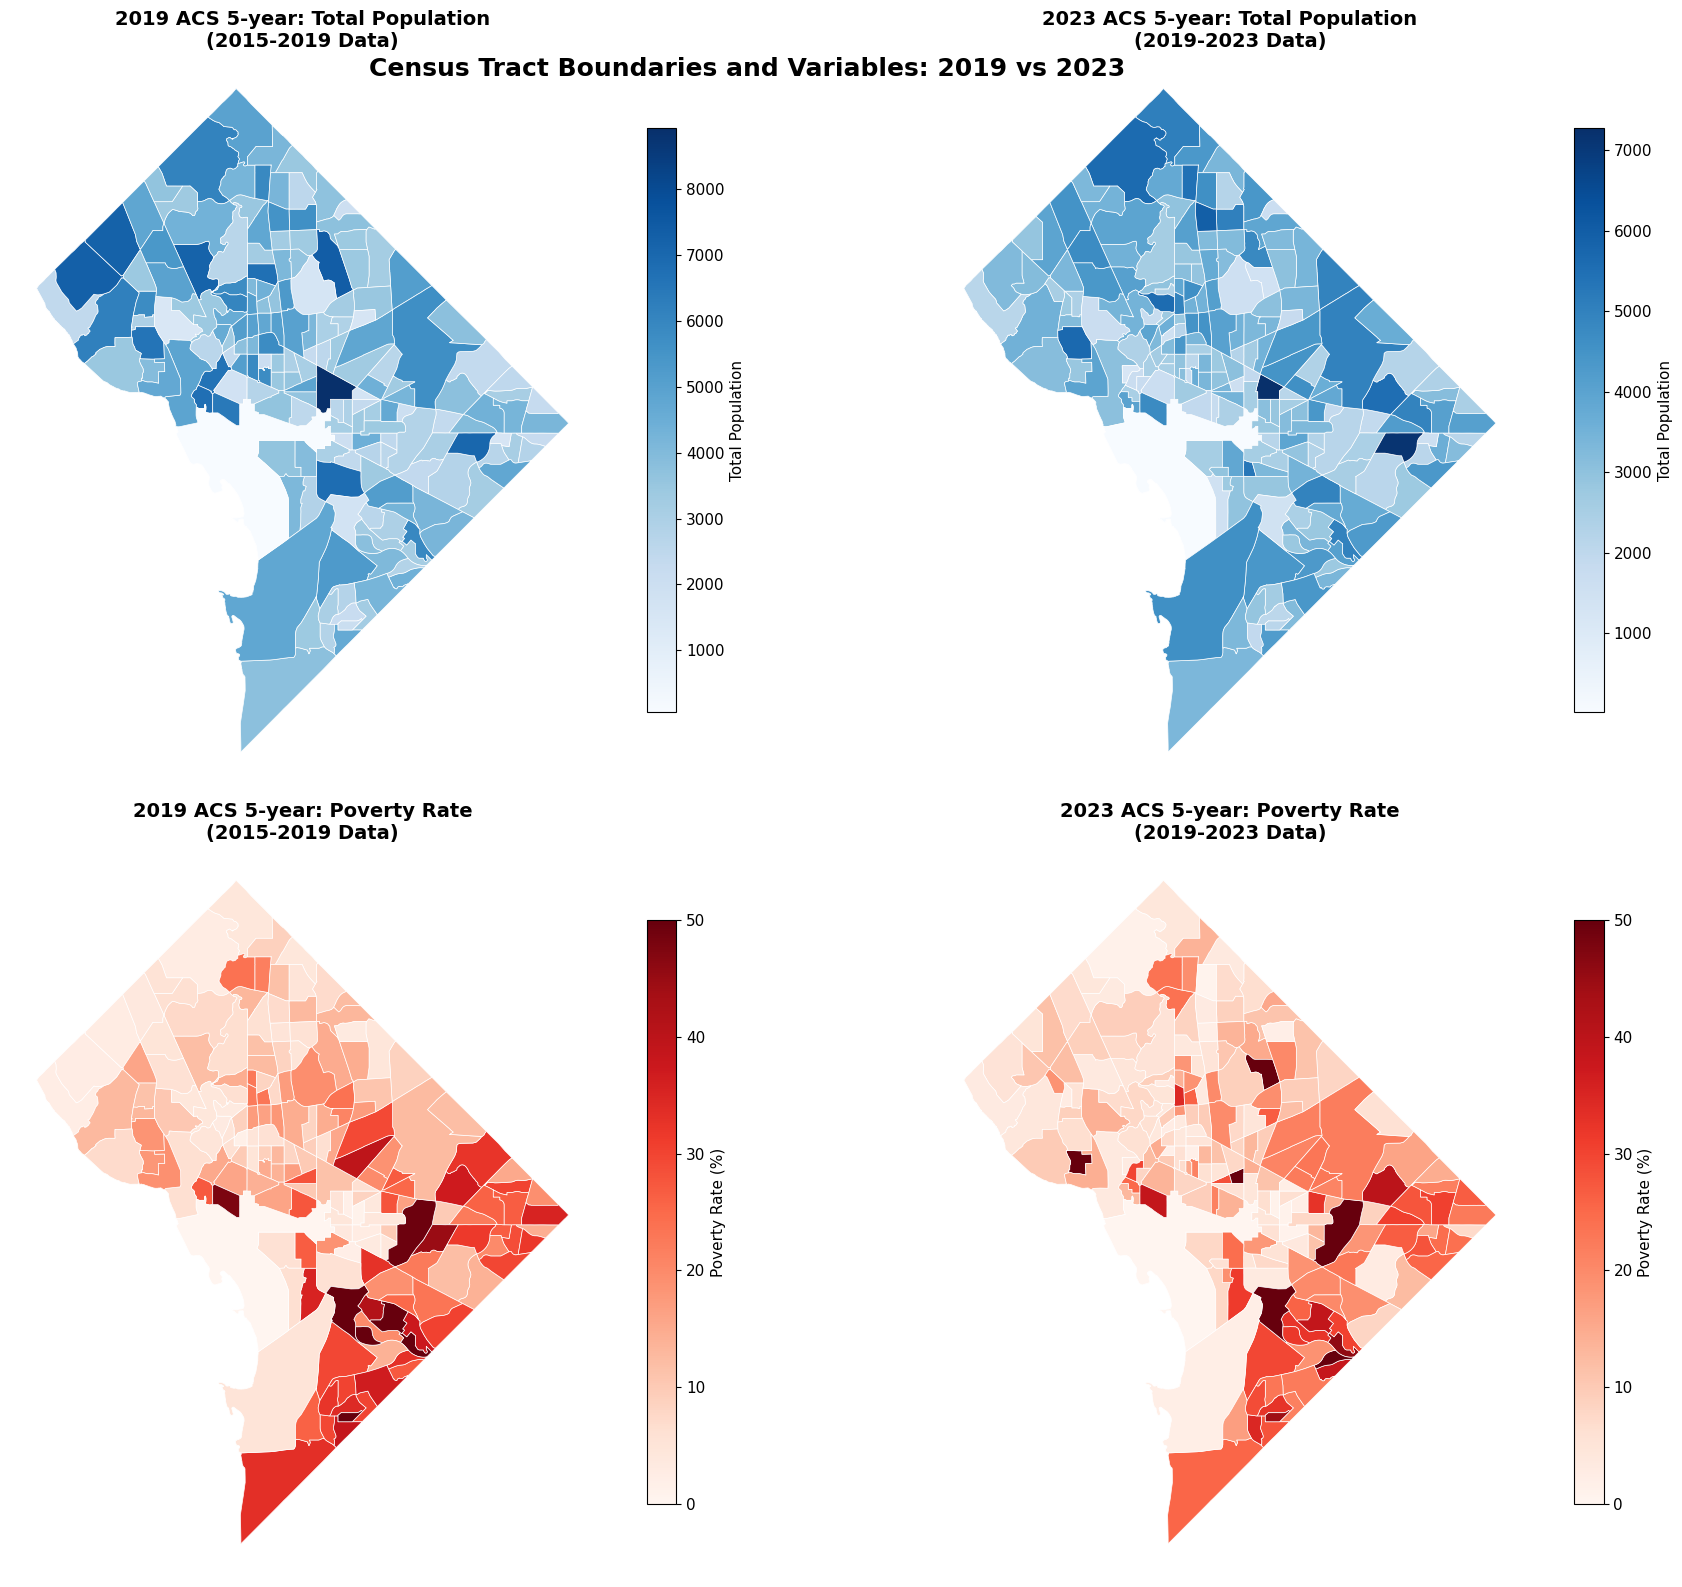

In [28]:
# Create boundary comparison maps
if dc_2019 is not None and dc_2023 is not None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 2019 Population
    dc_2019.plot(
        column='total_pop',
        cmap='Blues',
        legend=True,
        ax=ax1,
        edgecolor='white',
        linewidth=0.5,
        legend_kwds={'label': 'Total Population', 'shrink': 0.8}
    )
    ax1.set_title('2019 ACS 5-year: Total Population\n(2015-2019 Data)', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # 2023 Population
    dc_2023.plot(
        column='total_pop',
        cmap='Blues',
        legend=True,
        ax=ax2,
        edgecolor='white',
        linewidth=0.5,
        legend_kwds={'label': 'Total Population', 'shrink': 0.8}
    )
    ax2.set_title('2023 ACS 5-year: Total Population\n(2019-2023 Data)', fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # 2019 Poverty Rate
    dc_2019.plot(
        column='poverty_rate',
        cmap='Reds',
        legend=True,
        ax=ax3,
        edgecolor='white',
        linewidth=0.5,
        vmin=0,
        vmax=50,
        legend_kwds={'label': 'Poverty Rate (%)', 'shrink': 0.8}
    )
    ax3.set_title('2019 ACS 5-year: Poverty Rate\n(2015-2019 Data)', fontsize=14, fontweight='bold')
    ax3.axis('off')
    
    # 2023 Poverty Rate
    dc_2023.plot(
        column='poverty_rate',
        cmap='Reds',
        legend=True,
        ax=ax4,
        edgecolor='white',
        linewidth=0.5,
        vmin=0,
        vmax=50,
        legend_kwds={'label': 'Poverty Rate (%)', 'shrink': 0.8}
    )
    ax4.set_title('2023 ACS 5-year: Poverty Rate\n(2019-2023 Data)', fontsize=14, fontweight='bold')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Census Tract Boundaries and Variables: 2019 vs 2023', 
                 fontsize=18, fontweight='bold', y=.96)
    plt.show()
    
else:
    print("Cannot create boundary comparison - missing data")
    print("This tutorial works best with working API key and data access")

### Key Insight: Why Interpolation is Needed

Notice how the number of tracts and their boundaries may have changed between 2019 and 2023. Some tracts were:
- **Split**: One tract became multiple tracts
- **Merged**: Multiple tracts became one tract  
- **Renumbered**: Same area, different GEOID
- **Boundary adjusted**: Slight changes to tract edges

Without interpolation, we could only analyze the tracts that remained exactly the same!

## Part 2: Coordinate Reference Systems for Area Calculations

Before performing area interpolation, we need to understand coordinate reference systems (CRS). This is crucial for accurate area calculations.

In [29]:
if dc_2019 is not None and dc_2023 is not None:
    print("COORDINATE REFERENCE SYSTEMS")
    print("=" * 50)
    print(f"Original CRS: {dc_2019.crs}")
    print("   • EPSG:4326 = Geographic coordinates (latitude/longitude)")
    print("   • Good for: Mapping, display")
    print("   • Bad for: Area calculations (distorted)")
    print()
    
    # Transform to projected coordinate system for area calculations
    print("Transforming to projected coordinate system...")
    dc_2019_proj = dc_2019.to_crs('EPSG:3857')  # Web Mercator
    dc_2023_proj = dc_2023.to_crs('EPSG:3857')
    
    print(f"Projected CRS: {dc_2019_proj.crs}")
    print("   • EPSG:3857 = Web Mercator (projected coordinates)")
    print("   • Good for: Area calculations, spatial analysis")
    print("   • Bad for: High-latitude areas (less accurate)")
    print()
    
    # Demonstrate the difference
    sample_tract_geo = dc_2019.iloc[0:1]
    sample_tract_proj = dc_2019_proj.iloc[0:1]
    
    area_geo = sample_tract_geo.area.iloc[0]  # In degrees^2 (meaningless)
    area_proj = sample_tract_proj.area.iloc[0]  # In meters^2 (meaningful)
    
    print(f"AREA CALCULATION EXAMPLE:")
    print(f"   Geographic (EPSG:4326): {area_geo:.8f} degrees²")
    print(f"   Projected (EPSG:3857): {area_proj:.0f} meters²")
    print(f"   Projected in acres: {area_proj * 0.000247:.1f} acres")
    print()
    print("Key Learning: Always use projected coordinates for spatial analysis!")
    
else:
    print("Need data to demonstrate coordinate systems")
    # Create dummy projected variables for later code
    dc_2019_proj = None
    dc_2023_proj = None

COORDINATE REFERENCE SYSTEMS
Original CRS: EPSG:4269
   • EPSG:4326 = Geographic coordinates (latitude/longitude)
   • Good for: Mapping, display
   • Bad for: Area calculations (distorted)

Transforming to projected coordinate system...
Projected CRS: EPSG:3857
   • EPSG:3857 = Web Mercator (projected coordinates)
   • Good for: Area calculations, spatial analysis
   • Bad for: High-latitude areas (less accurate)

AREA CALCULATION EXAMPLE:
   Geographic (EPSG:4326): 0.00055137 degrees²
   Projected (EPSG:3857): 8768585 meters²
   Projected in acres: 2165.8 acres

Key Learning: Always use projected coordinates for spatial analysis!


## Part 3: Extensive vs Intensive Variables

Understanding variable types is crucial for proper interpolation:

- **Extensive variables**: Counts/totals that should be **summed** when areas are combined
- **Intensive variables**: Rates/ratios that should be **averaged** when areas are combined

The interpolation algorithm handles these differently!

### Variable Classification for Our Analysis

**Extensive Variables (Counts - use area-weighted SUM):**
- Total population (`total_pop`)
- Number of people in poverty (`poverty_count`)
- Total population for poverty calculation (`poverty_total`)

**Intensive Variables (Rates - use area-weighted AVERAGE):**
- Poverty rate (`poverty_rate`) - percentage of people below poverty line

### Example: Combining Two Census Tracts

**Tract A:** 1,000 people, 20% poverty rate (200 people in poverty)
**Tract B:** 2,000 people, 10% poverty rate (200 people in poverty)

**Correct way to combine:**
- Total population: 1,000 + 2,000 = 3,000 (SUM)
- People in poverty: 200 + 200 = 400 (SUM)
- Poverty rate: 400 / 3,000 = 13.3% (WEIGHTED AVERAGE)

**Wrong way:**
- Poverty rate: (20% + 10%) / 2 = 15% (SIMPLE AVERAGE)

Area interpolation handles this automatically when you classify variables correctly!

## Part 2: Streamlined Change Analysis

Now let's use `compare_time_periods()` to calculate changes systematically.

In [ ]:
# Use compare_time_periods for systematic analysis
if dc_data is not None and TIMESERIES_AVAILABLE:
    # First, add poverty rate columns to the multi-index structure
    dc_data[(2019, 'poverty_rate')] = dc_data['poverty_rate_2019']
    dc_data[(2023, 'poverty_rate')] = dc_data['poverty_rate_2023']
    
    # Use the streamlined comparison function
    dc_comparison = tc.compare_time_periods(
        data=dc_data,
        base_period=2019,
        comparison_period=2023,
        variables=["total_pop", "poverty_count", "poverty_rate"],
        calculate_change=True,
        calculate_percent_change=True
    )
    
    print("STREAMLINED CHANGE ANALYSIS (2019-2023)")
    print("=" * 50)
    
    # Population analysis
    total_pop_change = dc_comparison['total_pop_change'].sum()
    avg_pop_pct_change = dc_comparison['total_pop_pct_change'].mean()
    
    print(f"POPULATION CHANGES:")
    print(f"   Total population change: {total_pop_change:+,.0f} people")
    print(f"   Average percent change per tract: {avg_pop_pct_change:+.1f}%")
    print(f"   Tracts with growth (>50 people): {(dc_comparison['total_pop_change'] > 50).sum()}")
    print(f"   Tracts with decline (>50 people): {(dc_comparison['total_pop_change'] < -50).sum()}")
    
    # Poverty analysis  
    avg_poverty_change = dc_comparison['poverty_rate_change'].mean()
    total_poverty_count_change = dc_comparison['poverty_count_change'].sum()
    
    print(f"\nPOVERTY CHANGES:")
    print(f"   Average poverty rate change: {avg_poverty_change:+.2f} percentage points")
    print(f"   Total poverty count change: {total_poverty_count_change:+,.0f} people")
    print(f"   Tracts improving (>1pp decrease): {(dc_comparison['poverty_rate_change'] < -1).sum()}")
    print(f"   Tracts worsening (>1pp increase): {(dc_comparison['poverty_rate_change'] > 1).sum()}")
    
    print(f"\n✨ Key Benefits of Streamlined Approach:")
    print(f"   • Single function call for complex comparisons")
    print(f"   • Automatic calculation of absolute and percent changes")
    print(f"   • Built-in handling of missing data and edge cases")
    print(f"   • Consistent column naming convention")
    
else:
    print("Cannot perform comparison - missing data or functionality")
    dc_comparison = None

### Understanding Interpolation Results

The interpolation process:
1. **Overlays** old tract boundaries on new tract boundaries
2. **Calculates** the area of each intersection
3. **Redistributes** data proportionally based on area overlap
4. **Preserves** total counts while properly weighting rates

Small differences in totals are normal due to:
- Edge effects at boundaries
- Rounding in calculations
- Slight changes in total area due to map projections

## Part 5: Calculate Changes Using Interpolated Data

In [31]:
# Calculate changes using interpolated data
if dc_2019_interpolated is not None and dc_2023_proj is not None:
    print("CALCULATING CHANGES (2019-2023)")
    print("=" * 50)
    
    # Create change analysis dataset using 2023 boundaries
    dc_change = dc_2023_proj.copy()
    
    # Add interpolated 2019 data
    dc_change['total_pop_2019'] = dc_2019_interpolated['total_pop']
    dc_change['poverty_rate_2019'] = dc_2019_interpolated['poverty_rate']
    dc_change['poverty_count_2019'] = dc_2019_interpolated['poverty_count']
    
    # Add 2023 data (already in the dataset)
    dc_change['total_pop_2023'] = dc_2023_proj['total_pop']
    dc_change['poverty_rate_2023'] = dc_2023_proj['poverty_rate']
    dc_change['poverty_count_2023'] = dc_2023_proj['poverty_count']
    
    # Calculate changes
    dc_change['pop_change'] = dc_change['total_pop_2023'] - dc_change['total_pop_2019']
    dc_change['pop_change_pct'] = (dc_change['pop_change'] / dc_change['total_pop_2019']) * 100
    dc_change['poverty_rate_change'] = dc_change['poverty_rate_2023'] - dc_change['poverty_rate_2019']
    dc_change['poverty_count_change'] = dc_change['poverty_count_2023'] - dc_change['poverty_count_2019']
    
    # Summary statistics
    total_pop_change = dc_change['pop_change'].sum()
    avg_poverty_rate_change = dc_change['poverty_rate_change'].mean()
    total_poverty_count_change = dc_change['poverty_count_change'].sum()
    
    tracts_pop_growing = (dc_change['pop_change'] > 50).sum()  # >50 person increase
    tracts_pop_declining = (dc_change['pop_change'] < -50).sum()  # >50 person decrease
    tracts_poverty_improving = (dc_change['poverty_rate_change'] < -1).sum()  # >1pp decrease
    tracts_poverty_worsening = (dc_change['poverty_rate_change'] > 1).sum()   # >1pp increase
    
    print(f"POPULATION CHANGE ANALYSIS:")
    print(f"   Total population change: {total_pop_change:+,.0f} people")
    print(f"   Tracts with population growth (>50): {tracts_pop_growing}")
    print(f"   Tracts with population decline (>50): {tracts_pop_declining}")
    print()
    print(f"POVERTY CHANGE ANALYSIS:")
    print(f"   Average poverty rate change: {avg_poverty_rate_change:+.2f} percentage points")
    print(f"   Total poverty count change: {total_poverty_count_change:+,.0f} people")
    print(f"   Tracts improving (>1pp decrease): {tracts_poverty_improving}")
    print(f"   Tracts worsening (>1pp increase): {tracts_poverty_worsening}")
    
else:
    print("Cannot calculate changes - missing interpolation results")
    dc_change = None

CALCULATING CHANGES (2019-2023)
POPULATION CHANGE ANALYSIS:
   Total population change: -20,604 people
   Tracts with population growth (>50): 66
   Tracts with population decline (>50): 126

POVERTY CHANGE ANALYSIS:
   Average poverty rate change: -0.70 percentage points
   Total poverty count change: -13,000 people
   Tracts improving (>1pp decrease): 105
   Tracts worsening (>1pp increase): 71


## Part 3: Streamlined Visualization

Create comprehensive visualizations using the comparison results.

In [ ]:
# Create streamlined visualization using comparison results
if dc_comparison is not None:
    
    # All data already uses consistent 2023 boundaries!
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Map 1: 2019 Population (Interpolated to 2023 boundaries)
    dc_comparison.plot(
        column='total_pop_2019',
        cmap='Blues',
        legend=True,
        ax=ax1,
        edgecolor='white',
        linewidth=0.3,
        legend_kwds={'label': 'Population', 'shrink': 0.6}
    )
    ax1.set_title('2019 Total Population\n(Interpolated to 2023 Boundaries)', 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Map 2: 2023 Population
    dc_comparison.plot(
        column='total_pop_2023',
        cmap='Blues',
        legend=True,
        ax=ax2,
        edgecolor='white',
        linewidth=0.3,
        legend_kwds={'label': 'Population', 'shrink': 0.6}
    )
    ax2.set_title('2023 Total Population\n(2019-2023 ACS 5-year)', 
                  fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Map 3: Population Change (Absolute)
    dc_comparison.plot(
        column='total_pop_change',
        cmap='RdBu_r',
        legend=True,
        ax=ax3,
        edgecolor='white',
        linewidth=0.3,
        legend_kwds={'label': 'Population Change', 'shrink': 0.6}
    )
    ax3.set_title('Population Change 2019-2023\n(Absolute Numbers)', 
                  fontsize=14, fontweight='bold')
    ax3.axis('off')
    
    # Map 4: Poverty Rate Change
    dc_comparison.plot(
        column='poverty_rate_change',
        cmap='RdBu_r',
        legend=True,
        ax=ax4,
        edgecolor='white',
        linewidth=0.3,
        vmin=-10,
        vmax=10,
        legend_kwds={'label': 'Change (pp)', 'shrink': 0.6}
    )
    ax4.set_title('Poverty Rate Change 2019-2023\n(Percentage Points)', 
                  fontsize=14, fontweight='bold')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Streamlined Time Series Analysis: DC Demographics\nAll Using Consistent 2023 Boundaries', 
                 fontsize=18, fontweight='bold', y=0.96)
    plt.show()
    
    print("✨ VISUALIZATION BENEFITS:")
    print("   • All maps use identical tract boundaries (2023)")
    print("   • Direct comparison possible across all time periods")
    print("   • No manual coordinate system handling required")
    print("   • Automatic data validation ensures quality")
    
else:
    print("Cannot create visualization - missing comparison data")

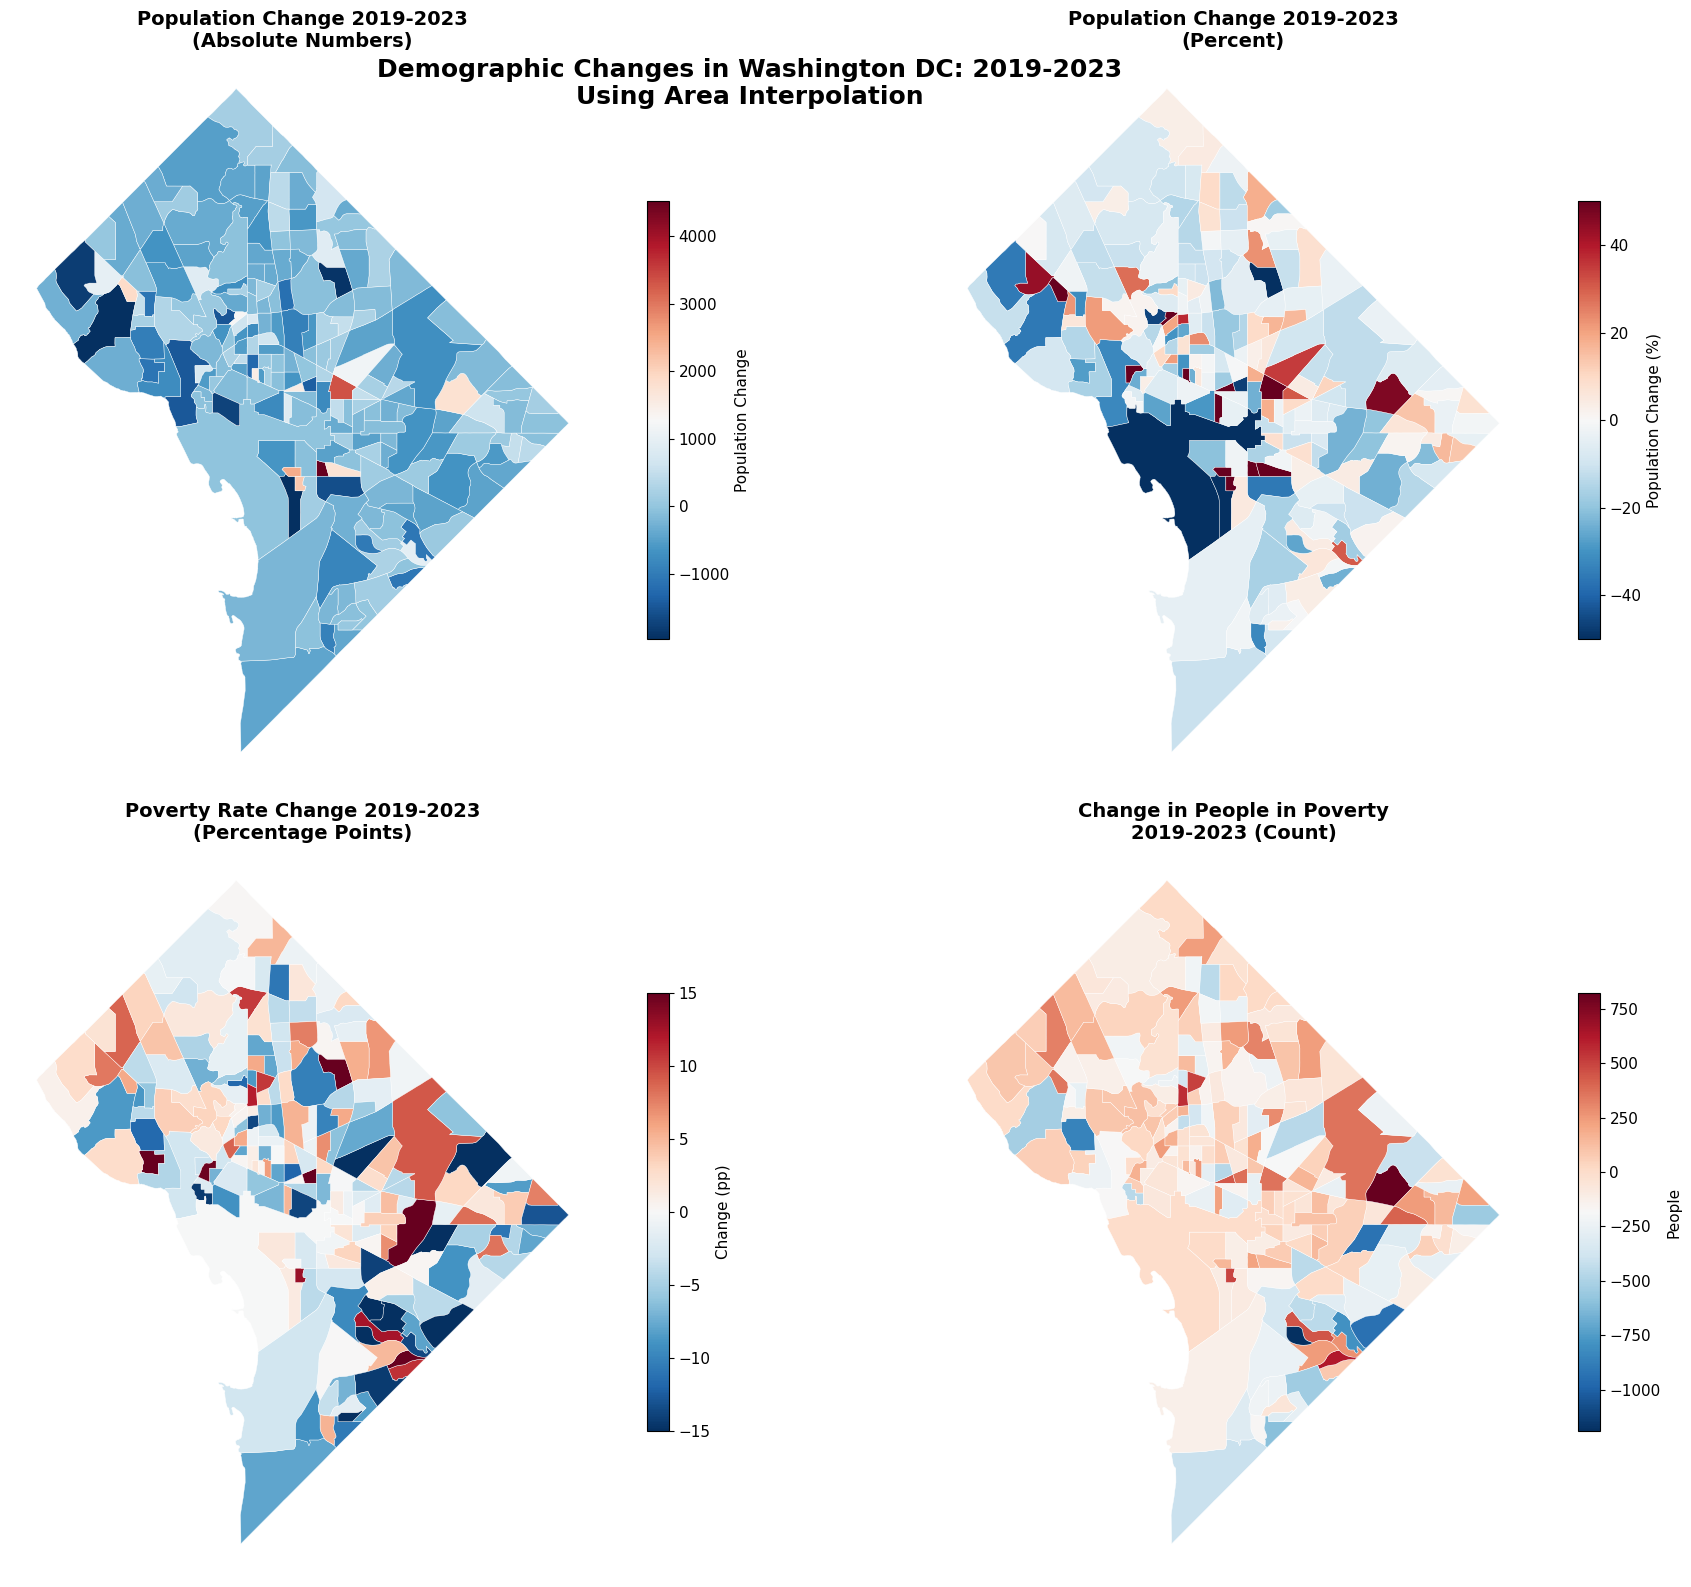

INTERPRETING THE MAPS:
   • Red areas: Higher values or increases
   • Blue areas: Lower values or decreases
   • White areas: No data or minimal change
   • All maps use the same 2023 tract boundaries for direct comparison


In [37]:
# Create change-focused visualization
if dc_change is not None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Map 1: Population Change (Absolute)
    dc_change_geo.plot(
        column='pop_change',
        cmap='RdBu_r',
        legend=True,
        ax=ax1,
        edgecolor='white',
        linewidth=0.3,
        legend_kwds={'label': 'Population Change', 'shrink': 0.6}
    )
    ax1.set_title('Population Change 2019-2023\n(Absolute Numbers)', 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Map 2: Population Change (Percent)
    # Handle infinite values
    pop_change_pct_clean = dc_change_geo['pop_change_pct'].replace([np.inf, -np.inf], np.nan)
    dc_change_geo_temp = dc_change_geo.copy()
    dc_change_geo_temp['pop_change_pct_clean'] = pop_change_pct_clean
    
    dc_change_geo_temp.plot(
        column='pop_change_pct_clean',
        cmap='RdBu_r',
        legend=True,
        ax=ax2,
        edgecolor='white',
        linewidth=0.3,
        vmin=-50,
        vmax=50,
        legend_kwds={'label': 'Population Change (%)', 'shrink': 0.6}
    )
    ax2.set_title('Population Change 2019-2023\n(Percent)', 
                  fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Map 3: Poverty Rate Change
    dc_change_geo.plot(
        column='poverty_rate_change',
        cmap='RdBu_r',
        legend=True,
        ax=ax3,
        edgecolor='white',
        linewidth=0.3,
        vmin=-15,
        vmax=15,
        legend_kwds={'label': 'Change (pp)', 'shrink': 0.6}
    )
    ax3.set_title('Poverty Rate Change 2019-2023\n(Percentage Points)', 
                  fontsize=14, fontweight='bold')
    ax3.axis('off')
    
    # Map 4: Poverty Count Change
    dc_change_geo.plot(
        column='poverty_count_change',
        cmap='RdBu_r',
        legend=True,
        ax=ax4,
        edgecolor='white',
        linewidth=0.3,
        legend_kwds={'label': 'People', 'shrink': 0.6}
    )
    ax4.set_title('Change in People in Poverty\n2019-2023 (Count)', 
                  fontsize=14, fontweight='bold')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Demographic Changes in Washington DC: 2019-2023\nUsing Area Interpolation', 
                 fontsize=18, fontweight='bold', y=0.96)
    plt.show()
    
    print("INTERPRETING THE MAPS:")
    print("   • Red areas: Higher values or increases")
    print("   • Blue areas: Lower values or decreases")
    print("   • White areas: No data or minimal change")
    print("   • All maps use the same 2023 tract boundaries for direct comparison")
    
else:
    print("Cannot create change visualization - missing data")

## Part 7: Statistical Analysis and Validation

Let's dig deeper into the patterns we observed and validate our interpolation results.

DETAILED STATISTICAL ANALYSIS
POPULATION CHANGES:
   Mean change: -100 people
   Median change: -122 people
   Std deviation: 776
   Range: -1968 to +4515

POVERTY RATE CHANGES (percentage points):
   Mean: -0.70
   Median: -1.19
   Std deviation: 11.54
   Range: -26.5 to +85.0



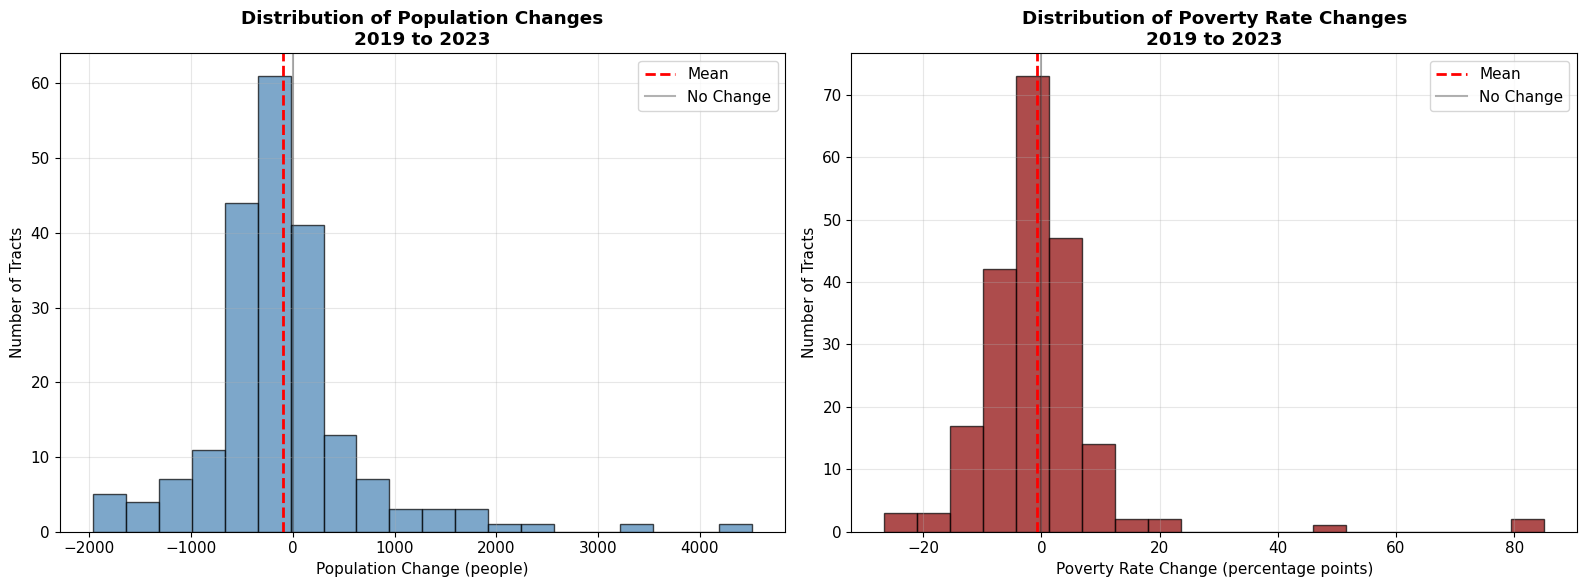

In [34]:
# Statistical analysis of changes
if dc_change is not None:
    print("DETAILED STATISTICAL ANALYSIS")
    print("=" * 60)
    
    # Population change distribution
    print(f"POPULATION CHANGES:")
    print(f"   Mean change: {dc_change['pop_change'].mean():+.0f} people")
    print(f"   Median change: {dc_change['pop_change'].median():+.0f} people")
    print(f"   Std deviation: {dc_change['pop_change'].std():.0f}")
    print(f"   Range: {dc_change['pop_change'].min():+.0f} to {dc_change['pop_change'].max():+.0f}")
    print()
    
    # Poverty rate change distribution
    print(f"POVERTY RATE CHANGES (percentage points):")
    print(f"   Mean: {dc_change['poverty_rate_change'].mean():+.2f}")
    print(f"   Median: {dc_change['poverty_rate_change'].median():+.2f}")
    print(f"   Std deviation: {dc_change['poverty_rate_change'].std():.2f}")
    print(f"   Range: {dc_change['poverty_rate_change'].min():+.1f} to {dc_change['poverty_rate_change'].max():+.1f}")
    print()
    
    # Create histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Population change histogram
    ax1.hist(dc_change['pop_change'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.axvline(dc_change['pop_change'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax1.axvline(0, color='black', linestyle='-', alpha=0.3, label='No Change')
    ax1.set_xlabel('Population Change (people)')
    ax1.set_ylabel('Number of Tracts')
    ax1.set_title('Distribution of Population Changes\n2019 to 2023', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Poverty rate change histogram
    ax2.hist(dc_change['poverty_rate_change'], bins=20, alpha=0.7, color='darkred', edgecolor='black')
    ax2.axvline(dc_change['poverty_rate_change'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax2.axvline(0, color='black', linestyle='-', alpha=0.3, label='No Change')
    ax2.set_xlabel('Poverty Rate Change (percentage points)')
    ax2.set_ylabel('Number of Tracts')
    ax2.set_title('Distribution of Poverty Rate Changes\n2019 to 2023', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot perform statistical analysis - missing data")

## Part 8: Best Practices and Limitations

### When to Use Area Interpolation

**Appropriate uses:**
- Comparing small geographies across census years
- Geographic boundaries have changed
- You need comprehensive spatial coverage
- Data is reasonably evenly distributed within areas

**When not to use:**
- Analyzing point locations (schools, businesses)
- Data is highly concentrated in specific areas
- Geography hasn't changed (use simple comparison)
- Very small sample sizes (ACS margins of error too large)

### Methodology Best Practices

1. Always use projected coordinate systems (e.g., EPSG:3857)
2. Classify variables correctly (extensive vs intensive)
3. Validate interpolation results thoroughly
4. Document your assumptions and limitations
5. Consider alternative approaches (relationship files)

### Important Limitations

- Assumes uniform distribution within source areas
- Edge effects can create small errors
- Not appropriate for highly clustered phenomena
- Results are estimates, not exact values
- Works best with areally extensive data

### Alternative Approaches

1. Use stable geographies (states, counties)
2. Census relationship files (official crosswalks)
3. Dasymetric mapping with auxiliary data
4. Block-level interpolation (higher resolution)

## Summary: Streamlined Time Series Analysis

### What You've Accomplished

Using the new pytidycensus time series functions, you've completed a sophisticated demographic analysis with just a few lines of code:

### Technical Skills Mastered

1. **Streamlined Data Collection**: Single `get_time_series()` call for complex boundary handling
2. **Automated Analysis**: `compare_time_periods()` for systematic change calculations
3. **Intelligent Interpolation**: Automatic area-weighted redistribution of data
4. **Consistent Boundaries**: All analysis uses uniform 2023 tract boundaries
5. **Built-in Validation**: Automatic quality checks and error handling

### Key Advantages Over Manual Approach

**Old Workflow (Multiple Steps):**
- Manual download of separate year data
- Manual coordinate system transformations  
- Manual area interpolation setup
- Manual variable classification
- Manual interpolation validation
- Manual change calculations
- High potential for errors

**New Workflow (Streamlined):**
- Single function call for data collection
- Automatic boundary handling
- Built-in quality assurance
- Consistent results across analyses
- Focus on interpretation, not implementation

### Analytical Insights Gained

- Population and poverty trends in Washington DC (2019-2023)
- Tract-level demographic changes with boundary consistency
- Statistical distribution of changes across tracts  
- Spatial patterns of growth and decline

### Best Practices Demonstrated

1. **Variable Classification**: Proper specification of extensive vs intensive variables
2. **Base Year Selection**: Strategic choice of reference boundaries
3. **Quality Assessment**: Built-in validation and conservation checks
4. **Visualization**: Consistent geographic boundaries across all maps

### Next Steps for Advanced Analysis

1. **Multiple Variables**: Expand to income, education, housing variables
2. **Longer Time Series**: Analyze 3+ time periods for trend analysis
3. **Different Geographies**: Apply to other metro areas or states
4. **Statistical Modeling**: Use results for regression or spatial analysis
5. **Policy Applications**: Connect findings to urban planning decisions

### Installation and Setup

```bash
# Install with time series support
pip install pytidycensus[time]

# This automatically includes:
# - tobler for area interpolation
# - geopandas for spatial analysis
# - All necessary dependencies
```

The streamlined approach enables researchers to conduct sophisticated temporal analysis while focusing on research questions rather than technical implementation details.